In [6]:
import os
import scenic
# scenic_script = "./examples/carla/Carla_Challenge/carlaChallenge5.scenic"
scenic_script = "./examples/carla/test2.scenic"
scenario = scenic.scenarioFromFile(scenic_script)

# from scenic.domains.driving.roads import ManeuverType, Network
# map_path = '/Users/edwardkim/Desktop/Scenic-devel/examples/carla/../../tests/formats/opendrive/maps/CARLA/Town05.xodr'
# network = Network.fromFile(map_path)

/Users/edwardkim/Desktop/Scenic_Query/Scenic/src/scenic/simulators/carla/model.scenic:56: UserWarning: the "carla" package is not installed; will not be able to run dynamic simulations
  warnings.warn('the "carla" package is not installed; '


In [22]:
from scenic.core.vectors import OrientedVector, Vector
import shapely.geometry
import matplotlib.pyplot as plt
from scenic.core.type_support import toVector
from scenic.core.regions import PolygonalRegion

print(scenario.egoObject.position.operands[0].dist.object)

Options(<LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <LaneSection>, <L

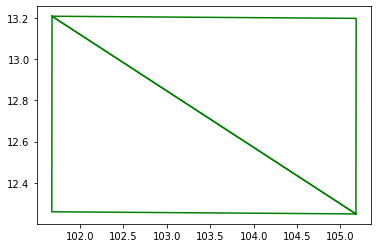

NotImplementedError: 

In [8]:
# creating a ego's visible sector region to find the lane's triangles is too much optimization, 
# and can violate what is actually written in the scenic script
from scenic.core.distributions import *
from scenic.core.vectors import Vector
from scenic.core.regions import SectorRegion
import math
import subprocess

debug = True
falseTest = False
x = 34.159077932706836
y = -200

resetConditionedObj(scenario)

# step 1: get rid of this optimization
ego = scenario.egoObject
smt_file_path = './test_smt_encoding.smt2'
open(smt_file_path, 'w').close()
writeSMTtoFile(smt_file_path, '(set-logic QF_NRA)')

cached_variables = {}
cached_variables['variables'] = []
vec = scenario.egoObject.position.sample()

if not falseTest:
    cached_variables['current_obj_pos'] = (vec.x, vec.y)
    ego_labelled_position = Vector(vec.x, vec.y)
else:
    cached_variables['current_obj_pos'] = (x, y)
    ego_labelled_position = Vector(x, y)
    
ego_visibleDistance = 100
ego_viewAngle = 135 #deg
ego_labelled_heading = 0 #deg
egoVisibleRegion = SectorRegion(ego_labelled_position, ego_visibleDistance, \
                                math.radians(ego_labelled_heading), math.radians(ego_viewAngle))
cached_variables['egoVisibleRegion'] = egoVisibleRegion.polygon
ego_pos_smt_var = ego.position.encodeToSMT(smt_file_path, cached_variables, debug = debug)

if ego_pos_smt_var is None:
    print("NOT FEASIBLE POSITION: "+ str(cached_variables['current_obj_pos']))

else:
    if not falseTest:
        (x_cond, y_cond) = vector_operation_smt(ego_pos_smt_var, "equal", (str(vec.x), str(vec.y)))
    else:
        (x_cond, y_cond) = vector_operation_smt(ego_pos_smt_var, "equal", (str(x), str(y)))

    writeSMTtoFile(smt_file_path, smt_assert(None, x_cond))
    writeSMTtoFile(smt_file_path, smt_assert(None, y_cond))
    writeSMTtoFile(smt_file_path, "(check-sat)")
    writeSMTtoFile(smt_file_path, "(exit)")

    # step 2: create the testing pipeline above
    if not debug:
        x = subprocess.call("./run_smt_encoding.sh")
        print(x)
        output = "UNSAT" if x==0 else "SATISFIED!"
        print(output)
    else:
        print("DEBUG MODE")

        
# step 3: add smt translation

# step 4: testing with Scenic scripts and their samples

In [ ]:
print(ego_pos_smt_var)

In [ ]:
import subprocess
x = subprocess.call("./run_smt_encoding.sh")
print(x)